In [87]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AdamW
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
from torch.utils.data import random_split
from sklearn.metrics import confusion_matrix
import numpy as np

In [70]:
train = pd.read_csv("../data/train.csv")
# test = pd.read_csv("../data/test.csv")
train, test = train_test_split(train, test_size=0.2)


In [38]:
train.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery ...,Milk,0
2,"I get no notification, however the app is real...",notification,0
3,"Love this app, but would love it even more if ...",view,1
4,it does not let me load a clip on the scene,load,0


In [41]:
data_plt = train['label'].value_counts()

In [62]:
def preprocess(df):
    df['text'] = df['text'].apply(lambda x : str(x).lower())
    df['label'] = df['label'].apply(lambda x : int(x))
    df['aspect'] = df['aspect'].apply(lambda x : str(x).lower())
    df['text'] = df['text'].apply(lambda x : str(x).translate(str.maketrans('','',string.punctuation))) #removing punctuation
    df['aspect'] = df['aspect'].apply(lambda x : str(x).translate(str.maketrans('','',string.punctuation))) #removing punctuation
    df['text'] = df['text'].apply(lambda x : str(x).translate(str.maketrans('','',string.digits))) #removing integers
    df['aspect'] = df['aspect'].apply(lambda x : str(x).translate(str.maketrans('','',string.digits))) #removing integers
    return df

[1680 1294 1026]


<BarContainer object of 3 artists>

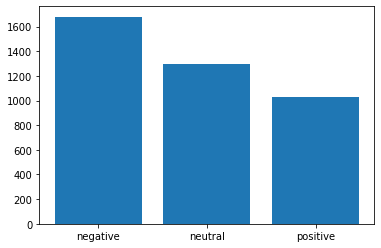

In [30]:
names = ['negative', 'neutral', 'positive']
# print(dir(data_plt))
print(data_plt.values)
vals = list(data_plt.values)
plt.bar(names,vals)

In [34]:
print(data_plt)

0    1680
1    1294
2    1026
Name: label, dtype: int64


In [83]:
def load():
    train_f1 = preprocess(train)
    test_f1 = preprocess(test)
    test_f1 = preprocess(test)
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    datasets = {
        "train": train_f1,
        "test": test_f1,
    }
    for i in datasets:
        data = datasets[i] # Get the dataset
        labels = list(data.label)
        encoded_tokenize = tokenizer(list(data.text),
         list(data.aspect), 
         padding=True, 
         truncation=True, 
         max_length = 512, 
         return_tensors = "pt")
        datasets[i] = torch.utils.data.TensorDataset(
            encoded_tokenize["input_ids"],
            encoded_tokenize["attention_mask"],
            torch.tensor(labels, dtype=torch.long).reshape(-1,1)
        )
    
    return datasets["train"], datasets["test"]


In [84]:
a,b = load()

In [89]:
def acc(confusion: np.array) -> float:
    return confusion.trace() / confusion.sum().sum()


def mcc(confusion: np.array) -> float:
    t = confusion.sum(0)
    p = confusion.sum(1)
    c = confusion.trace()
    s = confusion.sum().sum()

    num = c*s - t.dot(p)
    den = np.sqrt(s**2 - p.dot(p))*np.sqrt(s**2 - t.dot(t))

    return num / den

In [90]:
def train_absa(config: dict):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_labels = 3
    numeric_labels = list(range(num_labels))

    model = DistilBertModel.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
    model.train()
    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=config["lr"]
    )

    train_set, test_set = load()

    cutoff = int(0.8 * len(train_set))
    train_subset, val_subset = random_split(train_set, [cutoff, len(train_set) - cutoff])

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True
    )

    # Train
    total = (cutoff // config["batch_size"]) + int(cutoff % config["batch_size"] != 0)

    for epoch in range(config["epochs"]):

        for i, (input_ids, attention_mask, labels) in tqdm(enumerate(train_loader), total=total):
          
            optimizer.zero_grad()

            output = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                labels=labels.to(device)
            )
            loss = output["loss"]

            loss.backward()
            optimizer.step()

        # Validation
        running_loss = 0.0
        steps = 0
        confusion = np.zeros([num_labels, num_labels])

        for i, (input_ids, attention_mask, labels) in enumerate(val_loader):

            with torch.no_grad():

                output = model(
                    input_ids=input_ids.to(device),
                    attention_mask=attention_mask.to(device),
                    labels=labels.to(device)
                )
                loss, logits = output["loss"], output["logits"]

                confusion += confusion_matrix(
                    y_true=labels.flatten().cpu(), 
                    y_pred=torch.softmax(logits, -1).argmax(-1).cpu(), 
                    labels=numeric_labels
                )

                running_loss += loss.cpu().numpy()
                steps += 1

        summary = dict(
            loss=(running_loss / steps),
            accuracy=acc(confusion),
            mcc=mcc(confusion)
        )
        print(summary)


    torch.save(model, f"./absa-distil_bert.pt")
    print("Finished training.")

    return model

In [91]:
config ={
    "epochs": 4,
    "batch_size": 24,
    "lr": 2e-5
}

In [92]:
model = train_absa(config)

Downloading: 100%|██████████| 268M/268M [00:23<00:00, 11.3MB/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.